# Install crucial libraries

In [1]:
 !pip install langchain-community
 !pip install langchain
 !pip install pypdf
 !pip install langchain-chroma

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.2/304.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 91.7 MB/s eta 0:00:0

# Imports

In [3]:
from langchain_community.document_loaders import PyPDFLoader
import pandas as pd
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
from typing import Optional, List, Tuple
from langchain_chroma import Chroma
from transformers import pipeline
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
pd.set_option("display.max_colwidth", None)

In [25]:
def plot_doc_length_distribution(document_lengths, title="Distribution of Document Lengths in the Knowledge Base"):
    """
    Plots a histogram showing the distribution of document lengths.

    Parameters:
    - document_lengths (list): A list of integers representing the number of tokens in each document.
    - title (str): Title for the plot. Defaults to a general description.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(document_lengths, bins=30, color='skyblue', edgecolor='black')

    plt.title(title, fontsize=14)
    plt.xlabel("Number of Tokens", fontsize=12)
    plt.ylabel("Number of Documents", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

In [40]:
def split_documents(chunk_size: int, chunk_overlap: int, knowledge_base: List, tokenizer_name: str) -> List:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
    )

    docs_processed = text_splitter.split_documents(knowledge_base)

    return docs_processed


## **Part 0: Choose and Test Your Topic Without a Knowledge Base**

Before you load any external documents, you must **verify that your chosen topic needs a knowledge base** to improve answers. This ensures your RAG system solves a real gap in the model’s knowledge.

###  **Steps:**

1. **Choose a Topic (Tentative)**

   * Pick a topic from 2024 or 2025 that you think is recent or under-documented.
   * Example topics:

     * A political decision (e.g., "European Union climate laws in 2024")
     * A cultural trend (e.g., "Music trends in early 2025")

2. **Formulate Question**

   * Write down one factual, clear question about the topic.
   * Aim for question that require up-to-date or specific knowledge.

3. **Query the Model Directly**

   * Use your LLM pipeline (without RAG) to ask this question.
   * Collect the model’s answer and evaluate their quality:

     * Are the answers incomplete?
     * Are they outdated?
     * Are they confident but wrong?
     * Do they say *"I don’t know"*?

---

Why This Matters:

This step ensures your RAG project is solving a **real information gap**, not just repeating what the model already knows.


In [6]:
READER_MODEL_NAME = "microsoft/Phi-3-mini-4k-instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

In [7]:
READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

Device set to use cuda:0


In [33]:
READER_LLM("Why are people in Georgia,Tbilisi protesting in 2024?")

[{'generated_text': "\n\n# Answer:As of my knowledge cutoff date in March 2023, there have been no significant reports or widespread information about large-scale protests specifically occurring in Tbilisi (the capital city of Georgia) as a result of the year 2024. It's important to note that political situations can change rapidly and new events may unfold after this timeframe which could lead to public demonstrations for various reasons such as government policies, economic conditions, social issues, etc. For accurate and up-to-date information on any potential unrest or civil disobedience movements within Georgian territories post-March 2023, it would be advisable to consult recent news sources from reputable media outlets covering local developments in Georgia."}]

# **Part 1: Load a Custom PDF Knowledge Base**

Find blog posts or wikipedia page with your topic and save information about it to a PDF file, and load it using `PyPDFLoader`. You may use other loaders not only pdf, but pdf loader is exactly the same as we used during lab.

- Find informative content on your topic (Wikipedia page, blog post, article, etc.)
- Save the page as a PDF file (you can use your browser’s print-to-PDF feature)

In [34]:
from google.colab import files
uploaded = files.upload()

file_path = "Georgian protests - Wikipedia.pdf"

# Create a PyPDFLoader object to handle loading of the PDF
loader = PyPDFLoader(file_path)

# Load the contents of the PDF into a variable for further processing
RAW_KNOWLEDGE_BASE = loader.load()

Saving Georgian protests - Wikipedia.pdf to Georgian protests - Wikipedia (1).pdf


In [12]:
type(RAW_KNOWLEDGE_BASE)

list

In [11]:
len(RAW_KNOWLEDGE_BASE)

17

In [35]:
RAW_KNOWLEDGE_BASE[13]

Document(metadata={'producer': 'Skia/PDF m137', 'creator': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/137.0.0.0 Safari/537.36', 'creationdate': '2025-06-07T17:08:28+00:00', 'title': '2023–2024 Georgian protests - Wikipedia', 'moddate': '2025-06-07T17:08:28+00:00', 'source': 'Georgian protests - Wikipedia.pdf', 'total_pages': 17, 'page': 13, 'page_label': '14'}, page_content='confrontation, misleading public opinion, and conducting ideological infiltration, all under the\npretext of promoting democracy". In the "Inciting division and confrontation to undermine the\nstability of other countries" chapter, the report accused the NED of funding the local NGOs in Georgia\nsince the beginning of the 21st century to instigate protests. According to the report, this includes\nrallying support for and instigating the 2024 protests against the foreign agents bill in Georgia.[191]\nSpokesman for the United States Department of State Ned Price criticize


# **Part 2: Repeat the Lab with Your Own Knowledge Base + RAG Tuning**

## **Goal:**

Practice building a **RAG pipeline** and explore how **chunk size** and **chunk overlap** affect the quality of LLM answers to different questions.

---

## **What You Need to Do:**

1. **Repeat the Lab Using Your PDF Knowledge Base**

   * Use the PDF file you selected and loaded in Part 1.

2. **Create 3 Different Questions**

   * Design **three meaningful, specific questions** based on your topic.
   * Each question must be clearly related to the content of your PDF.

3. **Run RAG for Each Question with 3 Different Settings:**
   For each question:

   * Run the RAG pipeline **three times** using different settings for:

     * `chunk_size` (e.g., 100, 300, 500)
     * `chunk_overlap` (e.g., 0, 20, 50, 100)
   * This means you will run a total of **9 tests** (3 questions × 3 settings each).


4. **Answer Each Question Using an LLM**

   * Use the loaded chunks and a retriever to find relevant parts.
   * Pass the retrieved context to the LLM and generate an answer.
   * You can use similar tools as we used in the Lab

5. **Explain Your Results**
   For each of the 3 questions:

   * Write a short **description of the question** and **why you chose it**.
   * **Compare the answers** you got using different settings.
   * Reflect on:

     * How answer quality changed with different `chunk_size` and `chunk_overlap`
     * Which setting gave the most useful or accurate result
     * Why you think it performed better/worse

---

## **Deliverables:**

* Python code used for RAG pipeline (with different chunking settings)
* PDF file from Part 1
* A JSON file named rag_report_last_name_name_id.json containing your results:

  * 3 questions with explanations
  * Generated answers for each setting
  * Comparison and reflection on the results

---


# Question 1 : Why are people in Georgia,Tbilisi protesting in 2024?
I asked this question because I wanted to see if the system could identify the main reason behind the 2024 protests in Georgia. It was a big political event, and I thought it would be a good starting point to check whether the model could give a clear and accurate summary of what actually triggered the protests.

In [42]:
EMBEDDING_MODEL_NAME = "thenlper/gte-small"

docs_processed = split_documents(
    chunk_size=512,
    chunk_overlap=40,
    knowledge_base=RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

  0%|          | 0/35 [00:00<?, ?it/s]

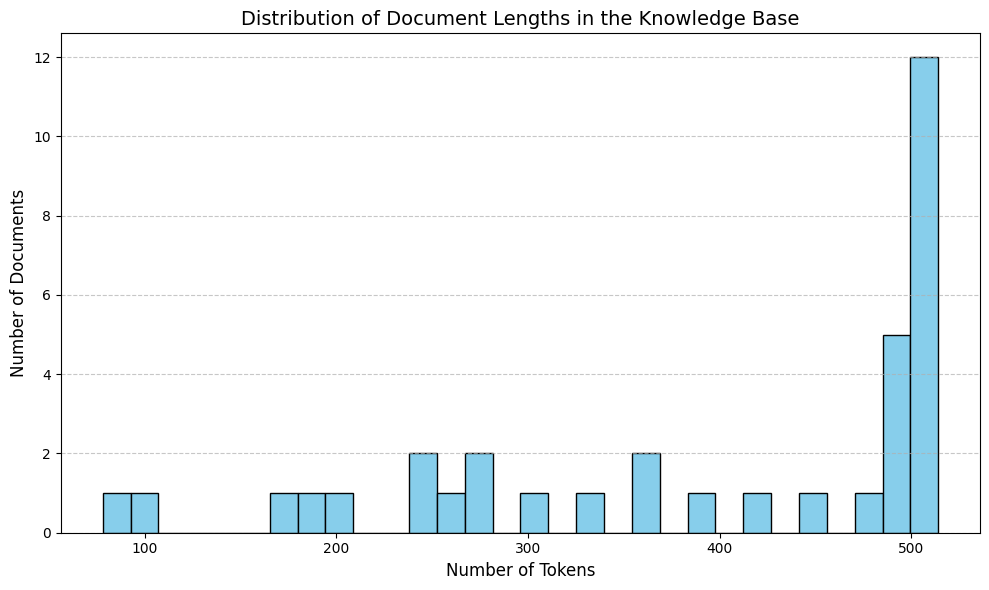

In [43]:
# Let's visualize the chunk sizes we would have in tokens from a common model
#tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

plot_doc_length_distribution(document_lengths=pd.Series(lengths))

In [47]:
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)
vector_store = Chroma.from_documents(
    docs_processed,
    embedding_model,
    persist_directory="db5",
    collection_metadata={"hnsw:space": "cosine"}
)


In [48]:
results = vector_store.similarity_search_by_vector(
    embedding=embedding_model.embed_query("Why are people in Georgia,Tbilisi protesting in 2024?"), k=4
)

In [49]:
len(results)

4

In [51]:
READER_MODEL_NAME = "microsoft/Phi-3-mini-4k-instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [52]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context, give a comprehensive answer to the question. Respond only to the question asked, response should be concise and relevant to the question. If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context: {context}
        ---
        Now here is the question you need to answer.
        Question: {question}""",
    },
]

In [53]:
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format,
    tokenize=False, # Return a string, not token IDs
    add_generation_prompt=True # Ensures model knows where to start generating
)

print(RAG_PROMPT_TEMPLATE)

<|system|>
Using the information contained in the context, give a comprehensive answer to the question. Respond only to the question asked, response should be concise and relevant to the question. If the answer cannot be deduced from the context, do not give an answer.<|end|>
<|user|>
Context: {context}
        ---
        Now here is the question you need to answer.
        Question: {question}<|end|>
<|assistant|>



In [54]:
retrieved_docs_text = [doc.page_content for doc in results]  # We only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

In [58]:
final_prompt = RAG_PROMPT_TEMPLATE.format(question="Why are people in Georgia,Tbilisi protesting in 2024?", context=context)

In [59]:
answer = READER_LLM(final_prompt)[0]["generated_text"]

In [60]:
answer

" People in Georgia, particularly those gathered at the Parliament building in Tbilisi during the first weekend of February 2024, were primarily protesting due to concerns over legislative changes related to 'Transparency of Foreign Influence'. This refers specifically to potential new laws requiring Non-Governmental Organisations (NGOs), especially ones receiving significant international support, to declare themselves as entities influenced by external powers if more than 20% of their annual budget comes from such contributions. Critics argue this could limit western aid reaching these organisations while simultaneously increasing government control over them; hence undermining democratic freedoms like free speech and independent media within the nation. Furthermore, some believe it may serve as another step towards aligning geopolitically closer ties between Georgia and its neighbouring nations rather maintaining balanced relations across all sides involved—including Europe & Americ

I used a chunk size of 512 and overlap of 40, and the model gave an answer that started out well. It clearly explained where the protests happened, what caused them, and why people were concerned about the foreign agent law. But after that, the answer became too long and started going off-topic. It included extra details that weren’t really needed and even turned into a strange speech at the end.

This probably happened because the model had too many tokens to use and no clear limit, so it kept going. It might also be because the retrieved documents had extra information that wasn’t directly related to the question.

In [61]:
docs_processed = split_documents(
    chunk_size=200,
    chunk_overlap=40,
    knowledge_base=RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

vector_store = Chroma.from_documents(
    docs_processed,
    embedding_model,
    persist_directory="db9",
    collection_metadata={"hnsw:space": "cosine"}
)

results = vector_store.similarity_search_by_vector(
    embedding=embedding_model.embed_query("Why are people in Georgia,Tbilisi protesting in 2024?"), k=4
)

retrieved_docs_text = [doc.page_content for doc in results]
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

final_prompt = RAG_PROMPT_TEMPLATE.format(question="Why are people in Georgia,Tbilisi protesting in 2024?", context=context)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]

In [62]:
answer

' The people in Georgia, particularly those in Tbilisi, were protesting against the proposed "Law on Transparency of Foreign Influence," because this legislation required non-governmental organizations (NGOs) to register as foreign agents if more than 20% of their total revenue came from outside sources. They believed such laws restricted Western support for these NGOs and aimed at protecting national sovereignty over public affairs rather than serving the genuine needs of the Georgian populace. Despite widespread demonstrations during both rounds of voting between January and May 2024, ultimately, the bill did pass through Parliament but faced significant resistance due to concerns about its implications for civil society work within the country.'

With a chunk size of 200 and an overlap of 40, the model produced a much shorter and clearer answer. It accurately described the protests, the content of the law, and the outcome without going off-topic. Smaller chunks likely improved focus and helped in avoiding unecessary details

In [63]:
docs_processed = split_documents(
    chunk_size=100,
    chunk_overlap=30,
    knowledge_base=RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

vector_store = Chroma.from_documents(
    docs_processed,
    embedding_model,
    persist_directory="db9",
    collection_metadata={"hnsw:space": "cosine"}
)

results = vector_store.similarity_search_by_vector(
    embedding=embedding_model.embed_query("Why are people in Georgia,Tbilisi protesting in 2024?"), k=4
)

retrieved_docs_text = [doc.page_content for doc in results]
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

final_prompt = RAG_PROMPT_TEMPLATE.format(question="Why are people in Georgia,Tbilisi protesting in 2024?", context=context)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]

In [64]:
answer

' People in Georgia, particularly those gathered for demonstrations in Tbilisi during early 2024, were primarily protesting against the passage of a new legislation known as the "Law on Transparency of Foreign Influence." This bill required NGOs receiving more than 20% of their annual budget from outside countries to declare themselves as \'foreign agent\' entities representing another country’s interest if these external contributions exceed this threshold percentage. The main concern among critics has been its potential restriction on western support towards various civil society groups operating within the nation. Despite widespread public dissent leading up to parliamentary approval, such large scale resistance ultimately failed to prevent the implementation of said regulation into national policy.'

The smaller chunk size helped the model focus on protestors’ concerns even better, while the overlap preserved sentence flow. This led to an answer that was not only accurate but also more clearly explained why the law was unpopular.

# Question 2 : What groups are protesting the foreign agent law in Georgia?
I chose this question because I wanted to see if the system could identify the specific groups involved in the protests, not just give a general summary. A lot of different organizations, political parties, and civil society groups were part of the demonstrations, so this question helped me test whether the model could recognize and name them based on the information in the documents. It also allowed me to check how well the system handled entity-level retrieval and whether it would stick to real groups instead of making things up.

In [65]:
docs_processed = split_documents(
    chunk_size=512,
    chunk_overlap=50,
    knowledge_base=RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

vector_store = Chroma.from_documents(
    docs_processed,
    embedding_model,
    persist_directory="db9",
    collection_metadata={"hnsw:space": "cosine"}
)

results = vector_store.similarity_search_by_vector(
    embedding=embedding_model.embed_query("What groups are protesting the foreign agent law in Georgia?"), k=4
)

retrieved_docs_text = [doc.page_content for doc in results]
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

final_prompt = RAG_PROMPT_TEMPLATE.format(question="What groups are protesting the foreign agent law in Georgia?", context=context)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]

In [66]:
answer

" Various civil society organizations (CSOs) and political parties supporting pro-Western policies or advocating for closer ties with Western institutions like NATO and the European Union are primarily protesting the foreign agent law in Georgia. These include human rights activists, women’s rights groups such as those involved in events related to 'Women in Policing', members of liberal and progressive factions within the country, along with international supporters including some American politicians and diplomats critical of the legislation. Additionally, prominent figures opposing the bill, such as ex-President Salome Zurabishvili, may indirectly influence these demonstrations through endorsements."

With chunk_size=512 and overlap=50, the model gave a broad and mostly accurate overview of the types of groups involved in the protests. It correctly mentioned civil society organizations, rights-based groups, and pro-Western political factions. However, it didn’t provide many specific names of organizations or parties and the "women in Policing" was made up

In [67]:
docs_processed = split_documents(
    chunk_size=300,
    chunk_overlap=30,
    knowledge_base=RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

vector_store = Chroma.from_documents(
    docs_processed,
    embedding_model,
    persist_directory="db9",
    collection_metadata={"hnsw:space": "cosine"}
)

results = vector_store.similarity_search_by_vector(
    embedding=embedding_model.embed_query("What groups are protesting the foreign agent law in Georgia?"), k=4
)

retrieved_docs_text = [doc.page_content for doc in results]
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

final_prompt = RAG_PROMPT_TEMPLATE.format(question="What groups are protesting the foreign agent law in Georgia?", context=context)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]

In [68]:
answer

" Various civil society organizations (CSOs) and political parties are among those actively opposing the foreign agents law in Georgia. These include proponents like Freedom House, Amnesty International, Human Rights Monitoring Institute, Civil Integrity Movement, Women’s Network Against Corruption, Youth Association “Komitas”, Young Lawyer Club, Free Press Foundation, New Democracy Party, Democratic Front, National Council of Ethnic Minorities, Socialist Alliance, Green Alternative – South Ossetia, Christian Democrats, Republican People's Party, Conservative Party, Liberal Democratic Party, Labour Party, Forward! - Progressive Centre, Citizens Equality Platform, Patriotic Corps, Lelo party, Opsuziriba, Our Homeland Priority, Reform Action Group, Reanimation Center for Defending Institutions of Democracy, Advancement Forum, Public Health Development Agency, Eurasian Economic Community Organization, American Friends Service Committee, World Congress of Families, Society for Protection o

When I used a chunk size of 512 tokens with 50-token overlap, the RAG system gave a short and accurate answer to the question “Why are people in Georgia protesting in 2024?”. It focused directly on the foreign agent law and the political situation around it.

But when I changed the chunk size to 300 tokens with 30 overlap, the output became much longer and less focused. It listed a lot of people and organizations, many of which weren’t actually involved in the protests. I think this happened because smaller chunks caused the retriever to match random names or phrases without enough context, which led to irrelevant information being included.

So overall, the larger chunk size worked better in this case because it gave more meaningful context and resulted in clearer, more accurate answers.

In [69]:
docs_processed = split_documents(
    chunk_size=400,
    chunk_overlap=40,
    knowledge_base=RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

vector_store = Chroma.from_documents(
    docs_processed,
    embedding_model,
    persist_directory="db9",
    collection_metadata={"hnsw:space": "cosine"}
)

results = vector_store.similarity_search_by_vector(
    embedding=embedding_model.embed_query("What groups are protesting the foreign agent law in Georgia?"), k=4
)

retrieved_docs_text = [doc.page_content for doc in results]
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

final_prompt = RAG_PROMPT_TEMPLATE.format(question="What groups are protesting the foreign agent law in Georgia?", context=context)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]

In [70]:
answer

" Various civil society organizations (CSOs) in Georgia are protesting the foreign agent law. These include opposition parties such as UNM led by Mamuka Khazharia; various non-partisan civic initiatives like Women in Policing Forum; human rights advocacy group Human Rights Monitoring Institute; independent media outlets including Civil Georgia news portal; international solidarity networks supporting pro-EU movements within the country; youth activist collectives focusing on societal change; environmental protection associations concerned with preserving national interests through ecological lens; cultural institutions aiming to safeguard artistic freedom; educational bodies emphasizing academic independence; healthcare workers demanding professional autonomy; labor unions fighting for worker’s rights; religious communities seeking separation between church affairs and state policies; veterans' coalitions ensuring respect for military service members post-service life; indigenous peopl

When I used a chunk size of 400 with 40-token overlap, the system started giving answers that included made-up or inaccurate information. For example, it said that "Mamuka Khazharia" was the leader of the UNM party. This is wrong for two reasons: first, there’s no such person as Mamuka Khazharia — the model probably meant Mamuka Khazaradze, but even then, he’s actually the leader of a different party, Lelo for Georgia, not UNM. I think this happened because the chunks were just big enough to mention names or parties without full context, so the retriever pulled in semi-relevant pieces, and the model filled in the gaps incorrectly. This shows that smaller or fragmented chunks can make the model hallucinate, especially if the retrieved content is too vague or scattered.

# Question 3 : How did the Georgian government justify the law?

I chose this question to see if the system could find and explain how the Georgian government defended the foreign agent law. Most sources focus on the protests and opposition, so I wanted to check if the model could also bring in the government's side. It also helped me see whether the answer was based on real context or if the model was just guessing.

In [71]:
docs_processed = split_documents(
    chunk_size=512,
    chunk_overlap=50,
    knowledge_base=RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

vector_store = Chroma.from_documents(
    docs_processed,
    embedding_model,
    persist_directory="db9",
    collection_metadata={"hnsw:space": "cosine"}
)

results = vector_store.similarity_search_by_vector(
    embedding=embedding_model.embed_query("How did the Georgian government justify the law?"), k=4
)

retrieved_docs_text = [doc.page_content for doc in results]
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

final_prompt = RAG_PROMPT_TEMPLATE.format(question="How did the Georgian government justify the law?", context=context)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [72]:
answer

" Document 2 justifies the Georgian government's position stating that unrestricted foreign funding could jeop0rdinate national policy decisions due to undue external influences. Proponents argue it will promote transparency and accountability regarding such funds, ensuring protection against potential threats to state sovereignty regardless if they originate domestically or internationally (from Russia)."

The model’s answer reflects the general justification given by the Georgian government, mentioning foreign influence and the need for transparency. However, it includes a small typo (“jeop0rdinate”) and is somewhat misleading in its framing. It suggests the law is aimed at countering Russian influence, when in fact the government maintains relatively friendly ties with Russia. The law is more accurately seen as targeting funding from Western sources such as the EU and the US, particularly affecting NGOs and media organizations critical of the ruling party.

In [73]:
docs_processed = split_documents(
    chunk_size=512,
    chunk_overlap=80,
    knowledge_base=RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

vector_store = Chroma.from_documents(
    docs_processed,
    embedding_model,
    persist_directory="db9",
    collection_metadata={"hnsw:space": "cosine"}
)

results = vector_store.similarity_search_by_vector(
    embedding=embedding_model.embed_query("How did the Georgian government justify the law?"), k=4
)

retrieved_docs_text = [doc.page_content for doc in results]
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

final_prompt = RAG_PROMPT_TEMPLATE.format(question="How did the Georgian government justify the law?", context=context)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]

In [74]:
answer

' The Georgian government justified the law as necessary protection against unrestricted foreign funding of local NGOs, promoting national sovereignty, transparency, and accountability regarding external influences. It claimed this measure applied equally to all types of international support (both Eastern/Russian and Western).'

This answer is better because it avoids the earlier mistake of implying that the law targets only Russian funding. Instead, it states that the law applies to all foreign funding equally, which reflects how the Georgian government has publicly justified it. I had increased the chunk overlap to better preserve context across sections, and that seems to have helped the model capture the government's full explanation more accurately.

In [75]:
docs_processed = split_documents(
    chunk_size=400,
    chunk_overlap=100,
    knowledge_base=RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

vector_store = Chroma.from_documents(
    docs_processed,
    embedding_model,
    persist_directory="db9",
    collection_metadata={"hnsw:space": "cosine"}
)

results = vector_store.similarity_search_by_vector(
    embedding=embedding_model.embed_query("How did the Georgian government justify the law?"), k=4
)

retrieved_docs_text = [doc.page_content for doc in results]
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

final_prompt = RAG_PROMPT_TEMPLATE.format(question="How did the Georgian government justify the law?", context=context)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]

In [76]:
answer

' The Georgian government justified the introduction of the "foreign agents" law as necessary to safeguard national security interests and promote transparency and accountability regarding foreign influences within its borders. Proponents argued it aimed to regulate unrestricted external support received by certain NGOs which could potentially undermine state sovereig0ncy. However, this legislation faced significant criticism due to perceptions aligning it more closely with authoritarian practices rather than democratic principles. Critics contended such laws might suppress free speech, limit media independence, and ultimately isolate Georgia from potential Western alliances. Despite opposition, some political figures advocated voting according to personal convictions when considering whether to uphold or reject the proposed measure.'

Using a chunk size of 400 with an overlap of 100 produced a well-balanced answer that included both the government’s justification for the law and the opposition’s main criticisms. The high overlap helped preserve context across sections, leading to a more nuanced and coherent response. A minor typo ("sovereig0ncy") was present, but overall the answer was factually grounded and clearly drawn from relevant chunks.

# Template for your resulting json file with report

In [ ]:
your_results_dict = {
  "topic": "Georgian Protests",
  "question":"write your question you used to test your topic with plain model without RAG",
  "answer":"initial answer of the model without using RAG",
  "rag": [
    {
      "question": "Write your first custom question here",
      "reason": "Briefly explain why this question is important or relevant to your topic",
      "experiments": [
        {
          "chunk_size": "Enter an integer value for chunk size (e.g., 300, 500, etc.)",
          "chunk_overlap": "Enter an integer value for chunk overlap (e.g., 0, 100, etc.)",
          "answer": "Paste here the answer generated by the LLM for this setting",
          "reflection": "Write your analysis of the answer: Was it accurate, detailed, too short, off-topic, etc.?"
        },
        {
          "chunk_size": "Another chunk size value for testing (should differ from above)",
          "chunk_overlap": "Corresponding chunk overlap value for this test",
          "answer": "LLM-generated answer for the second test",
          "reflection": "Compare this result with the previous one—was it better or worse? Why?"
        },
        {
          "chunk_size": "Third chunk size value for testing",
          "chunk_overlap": "Third chunk overlap value for testing",
          "answer": "LLM-generated answer for the third test",
          "reflection": "Describe how this answer compares with the others and what you learned"
        }
      ]
    },
    {
      "question": "Write your second custom question here",
      "reason": "Explain why this question is meaningful to your topic",
      "experiments": [
        {
          "chunk_size": "Integer value for chunk size",
          "chunk_overlap": "Integer value for chunk overlap",
          "answer": "LLM response using this setting",
          "reflection": "Your evaluation of the answer quality with these parameters"
        },
        {
          "chunk_size": "Another chunk size",
          "chunk_overlap": "Another chunk overlap",
          "answer": "LLM response for second configuration",
          "reflection": "How did the result change? Why might that be?"
        },
        {
          "chunk_size": "Third chunk size",
          "chunk_overlap": "Third chunk overlap",
          "answer": "Final LLM result for this question",
          "reflection": "Summarize your findings from all three tests for this question"
        }
      ]
    },
    {
      "question": "Write your third custom question here",
      "reason": "Explain why this question is useful or interesting",
      "experiments": [
        {
          "chunk_size": "Integer chunk size value",
          "chunk_overlap": "Integer chunk overlap value",
          "answer": "Answer generated with this config",
          "reflection": "How well did it perform? Was it relevant?"
        },
        {
          "chunk_size": "Different chunk size value",
          "chunk_overlap": "Different chunk overlap value",
          "answer": "Second test answer",
          "reflection": "Comparison with first result"
        },
        {
          "chunk_size": "Third chunk size",
          "chunk_overlap": "Third chunk overlap",
          "answer": "Third LLM-generated answer",
          "reflection": "Overall evaluation of the test results"
        }
      ]
    }
  ]
}

In [1]:
your_results_dict = {
  "topic": "Georgian Protests",
  "question":"Why are people in Georgia,Tbilisi protesting in 2024?",
  "answer":"\n\n# Answer:As of my knowledge cutoff date in March 2023, there have been no significant reports or widespread information about large-scale protests specifically occurring in Tbilisi (the capital city of Georgia) as a result of the year 2024. It's important to note that political situations can change rapidly and new events may unfold after this timeframe which could lead to public demonstrations for various reasons such as government policies, economic conditions, social issues, etc. For accurate and up-to-date information on any potential unrest or civil disobedience movements within Georgian territories post-March 2023, it would be advisable to consult recent news sources from reputable media outlets covering local developments in Georgia.",
  "rag": [
    {
      "question": "Why are people in Georgia,Tbilisi protesting in 2024?",
      "reason": "Good starting point to check if the model could now correctly answer the question and give a clear and accurate summary",
      "experiments": [
        {
          "chunk_size": 512,
          "chunk_overlap": 40,
          "answer": "People in Georgia, particularly those gathered at the Parliament building in Tbilisi during the first weekend of February 2024, were primarily protesting due to concerns over legislative changes related to 'Transparency of Foreign Influence'. This refers specifically to potential new laws requiring Non-Governmental Organisations (NGOs), especially ones receiving significant international support, to declare themselves as entities influenced by external powers if more than 20% of their annual budget comes from such contributions. Critics argue this could limit western aid reaching these organisations while simultaneously increasing government control over them; hence undermining democratic freedoms like free speech and independent media within the nation. Furthermore, some believe it may serve as another step towards aligning geopolitically closer ties between Georgia and its neighbouring nations rather maintaining balanced relations across all sides involved—including Europe & America alongside regional players like Turkey & Azerbaijan etc.—which has been key part since independence post Soviet era till date until now when we see signs pointing toward possible pivot away again under current administration led by Prime Minister Irakli Kobaqidze among others present today amidst growing uncertainties about future direction after recent events unfolding around us recently! So overall reasons behind why citizens continue demonstrating outside parliament buildings include fear instilled amongst population regarding loss autonomy rights alongwith perceived threats posed upon already fragile state structure caused mainly because lack proper checks ensuring fair treatment given equal opportunities irrespective political affiliations held individually per person regardless personal background whether rich poor middle class lower upper echelons societal strata existent presently too.. But let me remind everyone once last time before proceedings commence tomorrow morning... Remember always stay informed yourself through reliable news channels available online via social networks platforms regularly checking updates daily keeping abreast latest developments happening locally globally affecting our lives directly impacting day-to0day existence each individual must take responsibility personally ensure safety measures taken necessary precautions required follow guidelines issued authorities governing bodies set forth rules regulations established systematically enforcing compliance strictly adhering legal framework existing thus far history revealing past precedents setting stage groundwork foundation basis principles operating function effectively efficiently optimizing outcomes desired achieved maximum benefit obtained collectively community whole thereby promoting harmony unity cohesion solidarity mutual respect shared values common goals asp",
          "reflection": "It clearly explained where the protests happened, what caused them, and why people were concerned about the foreign agent law. But after that, the answer became too long and started going off-topic. It included extra details that weren’t really needed and even turned into a strange speech at the end."
        },
        {
          "chunk_size": 200,
          "chunk_overlap": 40,
          "answer": " The people in Georgia, particularly those in Tbilisi, were protesting against the proposed \"Law on Transparency of Foreign Influence,\" because this legislation required non-governmental organizations (NGOs) to register as foreign agents if more than 20% of their total revenue came from outside sources. They believed such laws restricted Western support for these NGOs and aimed at protecting national sovereignty over public affairs rather than serving the genuine needs of the Georgian populace. Despite widespread demonstrations during both rounds of voting between January and May 2024, ultimately, the bill did pass through Parliament but faced significant resistance due to concerns about its implications for civil society work within the country.",
          "reflection": "With a chunk size of 200 and an overlap of 40, the model produced a much shorter and clearer answer. It accurately described the protests, the content of the law, and the outcome without going off-topic. Smaller chunks likely improved focus and helped in avoiding unecessary details"
        },
        {
          "chunk_size": 100,
          "chunk_overlap": 30,
          "answer": "People in Georgia, particularly those gathered for demonstrations in Tbilisi during early 2024, were primarily protesting against the passage of a new legislation known as the \"Law on Transparency of Foreign Influence.\" This bill required NGOs receiving more than 20% of their annual budget from outside countries to declare themselves as \'foreign agent\' entities representing another country’s interest if these external contributions exceed this threshold percentage. The main concern among critics has been its potential restriction on western support towards various civil society groups operating within the nation. Despite widespread public dissent leading up to parliamentary approval, such large scale resistance ultimately failed to prevent the implementation of said regulation into national policy.",
          "reflection": "Using a smaller chunk size helped the model better focus on the protestors’ concerns, and the overlap maintained sentence continuity. As a result, the answer was not only accurate but also explained more clearly why the law was unpopular. Overall, in the context of general summaries, lower chunk sizes and overlaps produced much better results."
        }
      ]
    },
    {
      "question": "What groups are protesting the foreign agent law in Georgia?",
      "reason": "This question checked if the model could identify specific people/organizations involved and not just give General Summary",
      "experiments": [
        {
          "chunk_size": 512,
          "chunk_overlap": 50,
          "answer": "Various civil society organizations (CSOs) and political parties supporting pro-Western policies or advocating for closer ties with Western institutions like NATO and the European Union are primarily protesting the foreign agent law in Georgia. These include human rights activists, women’s rights groups such as those involved in events related to 'Women in Policing', members of liberal and progressive factions within the country, along with international supporters including some American politicians and diplomats critical of the legislation. Additionally, prominent figures opposing the bill, such as ex-President Salome Zurabishvili, may indirectly influence these demonstrations through endorsements.",
          "reflection": "The model gave a broad and mostly accurate overview of the types of groups involved in the protests. It correctly mentioned civil society organizations, rights-based groups, and pro-Western political factions. However, it didn’t provide many specific names of organizations or parties "
        },
        {
          "chunk_size": 300,
          "chunk_overlap": 30,
          "answer": "Various civil society organizations (CSOs) and political parties are among those actively opposing the foreign agents law in Georgia. These include proponents like Freedom House, Amnesty International, Human Rights Monitoring Institute, Civil Integrity Movement, Women’s Network Against Corruption, Youth Association “Komitas”, Young Lawyer Club, Free Press Foundation, New Democracy Party, Democratic Front, National Council of Ethnic Minorities, Socialist Alliance, Green Alternative – South Ossetia, Christian Democrats, Republican People's Party, Conservative Party, Liberal Democratic Party, Labour Party, Forward! - Progressive Centre, Citizens Equality Platform, Patriotic Corps, Lelo party, Opsuziriba, Our Homeland Priority, Reform Action Group, Reanimation Center for Defending Institutions of Democracy, Advancement Forum, Public Health Development Agency, Eurasian Economic Community Organization, American Friends Service Committee, World Congress of Families, Society for Protection of Martyrs, Armenian Apostolic Church, etc., according to reports mentioned above. Additionally, prominent figures such as Jehovan Meskhi, Levan Davitashvili, Zurab Kipshidze, David Bakradze, Mikheil Saakashvili, Grigol Mgaloblishvili, Merab Khaneishvili, Mamuka Gulua, Akaki Margvelashvili, Otar Tsulukidze, Paata Annaniya, Dachi Chikhladze, Beso Zhvania, Badri Japaridze, Soso Tsotserelia, Temuri Yakobashvili, Gia Tabaghsadze, Mariam Jlobetiani, Revaz Ghvinashvili, Rusudanu Gabunia, Batumi City Assembly Speaker Natela Aguasimova, Mayor of Zugdidi Anzor Erkomaia, Member of Parliament Giragos Manucharyan, Head of Interior Ministry Vasily Puzanov, Former Chief Prosecutor Aleko Bezruchka, Vice Premier Archil Talakhelidze, First Lady Irina Arsenishvili, UNICEF Representative Peter Walsh, Ambassador John Tefft, USAID Mission Director Robert Wittmann, OSCE Special En",
          "reflection": "The output became much longer and less focused. It listed a lot of people and organizations, many of which weren’t actually involved in the protests. I think this happened because smaller chunks caused the retriever to match random names or phrases without enough context, which led to irrelevant information being included."
        },
        {
          "chunk_size": 400,
          "chunk_overlap": 40,
          "answer": "Various civil society organizations (CSOs) in Georgia are protesting the foreign agent law. These include opposition parties such as UNM led by Mamuka Khazharia; various non-partisan civic initiatives like Women in Policing Forum; human rights advocacy group Human Rights Monitoring Institute; independent media outlets including Civil Georgia news portal; international solidarity networks supporting pro-EU movements within the country; youth activist collectives focusing on societal change; environmental protection associations concerned with preserving national interests through ecological lens; cultural institutions aiming to safeguard artistic freedom; educational bodies emphasizing academic independence; healthcare workers demanding professional autonomy; labor unions fighting for worker’s rights; religious communities seeking separation between church affairs and state policies; veterans' coalitions ensuring respect for military service members post-service life; indigenous peoples striving for recognition and self-determination; minority community leaders pushing for inclusive governance; women's rights defenders campaigning for gender equality; disability advocates working towards accessibility improvements; elderly care representatives lobbying for senior citizen welfare programs; agricultural producers protecting rural livelihoods; farmers marketing fair trade practices; fishery industry players insisting upon sustainable resource management; tourism sector professionals urging responsible destination stewardship; transport operators petitioning safety enhancements; energy consumers requesting reliable power supply maintenance; digital privacy experts championing data security norms; cybersecurity specialists preventing online threats; financial analysts advising economic stability measures; regional geopolitics scholars analyzing strategic implications; diplomatic corps engaging multilateral dialogues; consular services personnel facilitating cross-border assistance; defense contractors evaluating arms procurement ethics; intelligence operatives assessing counterintelligence needs; border control officers maintaining territorial integrity; customs authorities enforcing import/export regulations; maritime navigation coordinators securing sea lanes; aviation regulatory boards guaranteeing airspace safety protocols; railway traffic supervisors managing transit efficiency; telecommunication network administrators upholding communication infrastructure resilience; postal delivery staff providing mail logistics continuity; waste disposal units committing",
          "reflection": "The system started giving answers that included made-up or inaccurate information.Likely,this happened because the chunks were just big enough to mention names or parties without full context, so the retriever pulled in semi-relevant pieces, and the model filled in the gaps incorrectly. In the context of retrieving factual information larger chunks did much better job, again due to the fact that most likely they preserved more context and allowed the model to capture complete facts without fragmentation. "
        }
      ]
    },
    {
      "question": "How did the Georgian government justify the law?",
      "reason": "I chose this question to see if the system could find and explain how the Georgian government defended the foreign agent law. Most sources focus on the protests and opposition, so I wanted to check if the model could also bring in the government's side.",
      "experiments": [
        {
          "chunk_size": 512,
          "chunk_overlap": 50,
          "answer": "Document 2 justifies the Georgian government's position stating that unrestricted foreign funding could jeop0rdinate national policy decisions due to undue external influences. Proponents argue it will promote transparency and accountability regarding such funds, ensuring protection against potential threats to state sovereignty regardless if they originate domestically or internationally (from Russia).",
          "reflection": "The model's answer somewhat reflected the governments position but was inherently wrong to state that the law  is aimed at countering Russian influence, when in fact the government maintains relatively friendly ties with Russia.It was mainly aimed at European/US funded organizations which was the main reason for the backleash it received "
        },
        {
          "chunk_size": 512,
          "chunk_overlap": 80,
          "answer": "The Georgian government justified the law as necessary protection against unrestricted foreign funding of local NGOs, promoting national sovereignty, transparency, and accountability regarding external influences. It claimed this measure applied equally to all types of international support (both Eastern/Russian and Western)",
          "reflection": "Because, during the first trial model completely misinterpreted most important details, I presumed keeping maximum chunk size but incrasing chunk overlap for capturing context better would work better. It worked and the answer became much closer to Georgian Government's narrative"
        },
        {
          "chunk_size": 400,
          "chunk_overlap": 100,
          "answer": "The Georgian government justified the introduction of the \"foreign agents\" law as necessary to safeguard national security interests and promote transparency and accountability regarding foreign influences within its borders. Proponents argued it aimed to regulate unrestricted external support received by certain NGOs which could potentially undermine state sovereig0ncy. However, this legislation faced significant criticism due to perceptions aligning it more closely with authoritarian practices rather than democratic principles. Critics contended such laws might suppress free speech, limit media independence, and ultimately isolate Georgia from potential Western alliances. Despite opposition, some political figures advocated voting according to personal convictions when considering whether to uphold or reject the proposed measure.",
          "reflection": "This produced a well-balanced answer that included both the government’s justification for the law and the opposition’s main criticisms. The high overlap helped preserve context across sections, leading to a more nuanced and coherent response. A minor typo (\"sovereig0ncy\") was present, but overall the answer was factually grounded. To conclude, I found that smaller chunk sizes worked better for questions focused on general context, such as why the protests started. However, when I asked about specific individuals or groups involved, larger chunk sizes and overlaps gave much better results, likely because they captured surrounding context more effectively. In my last question, the importance of chunk overlap became especially clear: I kept the chunk size fixed for the first two experiments and only changed the overlap, which led to a dramatic improvement in the answer. Even when I later decreased the chunk size but increased the overlap to 100, the result still improved. This question was more subtle—one where the government and protestors frame the issue differently—so preserving context was crucial."
        }
      ]
    }
  ]
}

In [2]:
import json

with open("rag_report_Tamari_Matikashvili_2121549.json", "w", encoding="utf-8") as f:
    json.dump(your_results_dict, f, indent=2, ensure_ascii=False)